<a href="https://colab.research.google.com/github/xiaochengJF/DeepLearning/blob/DeepLearning/YOLOv3darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font face=STCAIYUN color=purple size=8>YOLOv3</font>
<font face=楷体 color=skyblue size=4>YOLO 是 You Only Look Once 的缩写</font>  
<font face=楷体 color=skyblue size=4>**全卷积神经网络** </font>  
<font face=楷体>
YOLO 仅使用卷积层，即：全卷积神经网络（FCN对于输入图像的大小不敏感） ，它拥有 75 个卷积层，带有跳跃连接和上采样层。不使用任何它形式的，使用步幅为 2 的卷积层代替池化层对特征图进行下采样，防止池化导致的低级特征丢失 
    
问题是：如果希望按批次处理图像（批量图像由 GPU 并行处理，这样可以提升速度），就需要固定图像的高度和宽度，便于将多个图像整合进一个大的批次（将许多 PyTorch 张量合并成一个）</font>  
 


<font face=楷体 color=skyblue size=4>**YOLOv3网络结构图** </font>  


<center>
<img src="https://img-blog.csdnimg.cn/20190824145218799.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MzcxMTU1NA==,size_16,color_FFFFFF,t_70">
</center>

<font face=楷体 color=skyblue size=4>**网络输出**</font>   

<center>
<img src="https://blog.paperspace.com/content/images/2018/04/yolo-5.png">
</center> 

<font face=楷体 color=skyblue size=4>锚点框（Anchor Box）</font>  
<font face=楷体>
直接预测边界框的宽度和高度比较直观，但训练中容易造成梯度不稳定，所以大部分目标检测器都预测对数空间（log-space）变换量，或者预测与预定义边界框（即锚点）之间的偏移量  
将这些变换被应用到锚点框来获得最终预测，YOLO v3 有三个锚点，所以每个单元格会预测 3 个边界框  
</font>   

<font face=楷体 color=skyblue size=4>中心坐标</font>    
<font face=楷体>
通过一个sigmoid函数对中心坐标预测，迫使输出介于0和1之间  
YOLO通常不会预测边界框中心的绝对坐标而是预测偏移量：  


*   相对于预测对象格单元格的左上角
*   由特征图中的单元格尺寸标准化，如上图：对狗狗中心的预测是（0.4，0.7），那么中心位于$13 \times 13$特征图上的（6.4，6.7）位置  
</font>


<font face=楷体 color=skyblue size=5>预测</font>  
<font face=楷体>每个bounding box预测5个值：$\color{pink}{t_x，t_y，t_w，t_h，t_o}$ （$t_o$类似YOLOv1中的confidence）  

*   $\color{pink}{t_x，t_y}$：经过sigmoid函数处理后范围在0到1之间，模型训练更加稳定  
*   $\color{pink}{c_x，c_y}$：表示一个cell和图像左上角的横纵距离 
*   $\color{pink}{p_w，p_h}$：表示bounding box的宽高 
</font>

 
$$
\begin{aligned} b_{x} &=\sigma\left(t_{x}\right)+c_{x} \\ b_{y} &=\sigma\left(t_{y}\right)+c_{y} \\ b_{w} &=p_{w} e^{t_{w}} \\ b_{h} &=p_{h} e^{t_{h}} \\ \operatorname{Pr}(\text { object }) * I O U(b, \text { object }) &=\sigma\left(t_{o}\right)\end{aligned}
$$

<font face=楷体 color=yellow>在Faster R-CNN中：</font>
$$\begin{align}
t_x &= (x - x_a) /w_a \ ,\  \ t_y = (y - y_a) / h_a\\[1ex]t_w &= \log(w/ w_a), \quad \ \  t_h = \log(h/h_a)\\[1ex]t_x^* &= (x^* - x_a) / w_a,\  t_y^* = (y^* - y_a) /h_a\\[1ex]t_w^* &= \log(w^* - w),\ \  h_h^* = \log(h^*/h_a)
\end{align}$$  

<font face=楷体 color=skyblue size=4>边界框的尺寸</font>   
<font face=楷体>
将输出进行对数变换乘以锚来预测边界框的尺寸  
预测结果$b_w$和$b_h$由图像的高度和宽度标准化，如果狗的预测框为$（0.3，0.8）$，那么$13 \times 13$特征图上的实际宽度和高度是$（13 \times 0.3,13 \times 0.8）$
</font>

<center>
<img src="https://blog.paperspace.com/content/images/2018/04/yolo-regression-1.png">
</center>

<font face=楷体 color=skyblue size=4>Score</font>  
<font face=楷体>
对象得分通过sigmoid转换到0、1之间，可以解释为概率，红色和相邻的网格应该接近1，而角落的网格应该接近0 
</font>  

<font face=楷体 color=skyblue size=4>Class Confidences</font>   
<font face=楷体>
v3使用sigmoid代替softmax进行分类，原因是Softmax假设所有类别是互斥的，即：如果一个对象属于一个类，那么就一定不属于另一个类（COCO数据库是可以的但如：医生和人就不成立了）  
</font>   
<font face=楷体 color=skyblue size=4>多尺度预测</font>   
<font face=楷体>
基于三种不同尺寸的特征图进行检测，<font color=skyblue>有助于检测小物体</font>。如：输入尺寸为$416 \times 416$，在$13 \times 13,26 \times 26,52 \times 52$的特诊图上进行检测  
每个尺度上，每个单元格使用3个anchors预测3个边界框，使得使用的anchors总数为9.（<font color=skyblue>不同尺度上的anchors不同</font>）  
</font> 

<center>
<img src="https://blog.paperspace.com/content/images/2018/04/yolo_Scales-1.png">
</center>

<font face=楷体 color=skyblue size=5>输出处理</font>  
<font face=楷体>  
对于尺寸为$416\times 416$的图像，YOLO预测$（（52\times 52）+（26\times 26）+ 13\times 13））×3 = 10647$个边界框  
<font color=skyblue>
通过对象置信度进行阈值处理  
非极大抑制（NMS）
</font>
</font>


# 导入相关模块

In [47]:
import glob
import random
import os
import sys
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from __future__ import division
import math
import time
import datetime
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import tensorflow as tf

from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
from terminaltables import AsciiTable

# 搭建模型
<font face=楷体>

* 解析模型参数
* 构件模块
* Darknet搭建
</font>

## 解析配置文件
<font face=楷体>

* parse_cfg 解析模型参数，将 <font color=skyblue size=4>**Net 、  Convolutional  、 Shortcut  、Upsample 、 Route 、 YOLO**</font> 等模型结构信息以列表的形式返回，便于后面模型搭建
* parse_data_config 解析数据集路径
</font> 

In [3]:
def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines]  # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['):  # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options

## 构建模块

<font face=楷体>

* convolutional卷积层
* maxpool最大池化（可选）
* upsample上采样
* route层
* shortcut跳跃连接
* yolo层
</font>

<font face=楷体 color=skyblue size=4>**create_modules 函数用 parse_cfg 函数返回的模型信息列表构建网络模块：**</font>

<font face=楷体>

*   先定义变量 hyperparams，来存储该网络的信息

*  当添加 nn.ModuleList 作为 nn.Module 对象的一个成员时（即添加模块到网络），所有 nn.ModuleList 内部的 nn.Module 对象（模块）的 parameter 也被添加   作为 nn.Module 对象（即网络添加 nn.ModuleList 作为其成员）的 parameter

*   卷积核的深度是由上一层的卷积核数量（或特征图深度）决定的，需要追踪上一层卷及数量。路由层（route layer）从前面层得到特征图，不仅需要追踪前一层的卷积核数量，还需要追踪之前每一层，这意味着需要持续追踪被应用卷积层的卷积核数量，用变量 output_filters 保存

*  nn.Sequential 类能让nn.Module 对象有序执行，用 nn.Sequential将一个模块的多个层串起来
    
</font>  

<font face=楷体 color=skyblue size=4>**为什么要一个空的层？**</font>  
<font face=楷体>
*   如果像其它层一样，创建路由层需要构建一个 nn.Module 对象并初始化，然后在 forward 函数中拼接特征图，但拼接操作的代码相当简短（ torch.cat），像其它层一样设计route层将导致不必要的抽象，增加代码。可以用一个空的虚拟层代替路由层，然后 forward 函数中直接执行拼接操作  
*   shortcut层是一个简单的add操作，也用一个空的虚拟层代替
</font>

<font face=楷体 color=skyblue size=4>多尺度检测</font> 
<font face=楷体> 

*   在特征图上进行多尺度预测, 在grid每个位置都有三个不同尺度的锚点.predict_transform()利用一个scale得到的feature map预测得到的每个anchor的属性(x,y,w,h,s,s_cls1,s_cls2...),其中x,y,w,h是在网络输入图片坐标系下的值，s是方框含有目标的置信度得分，s_cls1,s_cls_2等是方框所含目标对应每类的概率 

*   输入的feature map(prediction变量) 维度为<font color=pink>【batch_size, num_anchors*bbox_attrs, grid_size, grid_size】</font>(一个batch：$B\times C\times H\times W$)，这种格式对于输出处理过程（例如通过目标置信度进行阈值处理、添加对中心的网格偏移、应用锚点等）不方便
*   将维度变换成<font color=pink>【batch_size, grid_size*grid_size*num_anchors, 5+类别数量】</font>的tensor，同时得到每个方框在网络输入图片$(416\times 416)$坐标系下的(x,y,w,h)以及方框含有目标的得分以及每个类的得分
* 由于检测是在三个尺度上进行的，预测图的维度将是不同的。虽然三个特征图的维度不同，但对它们执行的输出处理过程是相似的

</font>


<center>
<img src="https://blog.paperspace.com/content/images/2018/04/bbox_-2.png#pic_center">
</center>

<font face=楷体 color=green size=4>**绿色链接:**</font>  
<font face=楷体>
【1】[nn.Conv2d 、nn.BatchNorm2d](https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch-nn/#torchnn)  
【2】[torch.nn.Upsample](https://pytorch.org/docs/stable/nn.html?highlight=nn%20upsample#torch.nn.Upsample)  
【3】[darknet 所有层功能说明 ](https://blog.csdn.net/zhuiqiuk/article/details/88187034)  
【4】[nn.Module](https://blog.csdn.net/u012609509/article/details/81203436) 
</font>

In [4]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)  # 追踪每层的filter

    return hyperparams, module_list


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf  # 预测为正、分类正确、真实含目标
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)  # IoU>0.5数量/所有预测为Positive的数量
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss

## Darknet模型搭建
<font face=楷体 color=skyblue size=4>加载权重</font>   
<font face=楷体 color=skyblue>权重是如何存储：</font>  

<font face=楷体>
权重只属于<font color=skyblue>批量归一化层（batch norm layer）和卷积层</font>  两种类型的层，储存顺序和配置文件中定义层级的顺序完全相同  
    
下图展示了权重如何储存：
</font>

![替代文字](https://blog.paperspace.com/content/images/2018/04/wts-1.png)

<font face=楷体>
<font color=skyblue>Variable是tensor的外包装，data属性存储着tensor数据，grad属性存储关于该变量的导数，creator是代表该变量的创造者</font> 

<font face=楷体 color=green size=4>绿色链接</font>  
【1】[Tensor and tensor.data](https://discuss.pytorch.org/t/tensor-and-tensor-data/18427)  
【2】[autograd 及Variable](https://zhuanlan.zhihu.com/p/34298983)  
【3】[What about .data?](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/#what-about-data)



In [5]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []  # layer_outputs储存每一层的特征用于跳跃连接
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

# Data
<font face=楷体 color=skyblue size=4> 
数据加载及增强
</font>
<font face=楷体>
* horisontal_flip、pad_to_square、resize、random_resize
*ImageFolder用于detect时加载数据
*ListDataset用于训练时加载数据</font>

<font face=楷体 color=skyblue size=4>
OpenCV读取图片的数据形式与Pytorch读取的格式不同  
$CV:\color{pink} {RGB}\color{yellow}\Longrightarrow  Torch: \color{pink}{BGR}\ \ \ \color{pink}{\mathrm 【height \times width \times channel】\Longrightarrow 【channel \times height \times width】}$
</font>
<br/>

<font face=楷体 color=green size=4>
绿色链接：
</font>
<br/>


【1】<font face=楷体>[一文弄懂Pytorch的DataLoader, DataSet, Sampler之间的关系](https://www.cnblogs.com/marsggbo/p/11308889.html)
</font>


In [6]:
def horisontal_flip(images, targets):
    images = torch.flip(images, [-1])
    targets[:, 2] = 1 - targets[:, 2]
    return images, targets

def pad_to_square(img, pad_value):
    """
    填充短边
    """
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def random_resize(images, min_size=288, max_size=448):
    new_size = random.sample(list(range(min_size, max_size + 1, 32)), 1)[0]
    images = F.interpolate(images, size=new_size, mode="nearest")
    return images


class ImageFolder(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.img_size = img_size

    def __getitem__(self, index):
        img_path = self.files[index % len(self.files)]
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        img, _ = pad_to_square(img, 0)
        # Resize
        img = resize(img, self.img_size)

        return img_path, img

    def __len__(self):
        return len(self.files)


class ListDataset(Dataset):
    def __init__(self, list_path, img_size=416, augment=True, multiscale=True, normalized_labels=True):
        with open(list_path, "r") as file:
            self.img_files = file.readlines()

        self.label_files = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.img_files
        ]
        self.img_size = img_size
        self.max_objects = 100
        self.augment = augment
        self.multiscale = multiscale
        self.normalized_labels = normalized_labels
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()

        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))

        # Handle images with less than three channels
        if len(img.shape) != 3:
            img = img.unsqueeze(0)
            img = img.expand((3, img.shape[1:]))

        _, h, w = img.shape
        h_factor, w_factor = (h, w) if self.normalized_labels else (1, 1)
        # Pad to square resolution
        img, pad = pad_to_square(img, 0)
        _, padded_h, padded_w = img.shape

        # ---------
        #  Label
        # ---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()

        targets = None
        if os.path.exists(label_path):
            boxes = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
            # Extract coordinates for unpadded + unscaled image
            x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
            y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
            x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
            y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
            # Adjust for added padding
            x1 += pad[0]
            y1 += pad[2]
            x2 += pad[1]
            y2 += pad[3]
            # Returns (x, y, w, h)
            boxes[:, 1] = ((x1 + x2) / 2) / padded_w
            boxes[:, 2] = ((y1 + y2) / 2) / padded_h
            boxes[:, 3] *= w_factor / padded_w
            boxes[:, 4] *= h_factor / padded_h

            targets = torch.zeros((len(boxes), 6))
            targets[:, 1:] = boxes

        # Apply augmentations
        if self.augment:
            if np.random.random() < 0.5:
                img, targets = horisontal_flip(img, targets)

        return img_path, img, targets

    def collate_fn(self, batch):
        paths, imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
        # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        self.batch_count += 1
        return paths, imgs, targets

    def __len__(self):
        return len(self.img_files)

# Tools
<font face=楷体 color=skyblue size=4> 
工具函数
</font>
<font face=楷体>
* to_cpu、load_classes加载类名、weights_init_normal初始化权重
* rescale_boxes缩放目标框、xywh2xyxy转换框格式、bbox_wh_iou、bbox_iou计算IoU
* ap_per_class、compute_ap、get_batch_statistics
* non_max_suppression
* build_targets


<font face=楷体 color=green size=4>绿色链接：</font>

【1】[Merge overlapping bboxes by order of confidence](https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/220)  
【2】[if iou >= iou_threshold and box_index not in detected_boxes:](https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/233)  
【3】[AP、Precision、Recall、mAP 、Roc](https://blog.csdn.net/weixin_43711554/article/details/104753262)
</font>

In [7]:
def to_cpu(tensor):
    return tensor.detach().cpu()


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))  # 补成闭区间
    mpre = np.concatenate(([0.0], precision, [0.0]))  

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])  # 保证其单调递减

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]  # 找出相邻两个值不一样的地方

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # 求PR曲线的面积即ap
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                # 得到预测框和目标框最大IoU，以及相应在目标框中的索引(与目标框类别的索引对应)
                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0) 
                # IoU>=阈值，类别正确则统计为 True Positive 
                if iou >= iou_threshold and box_index not in detected_boxes and pred_label == target_labels[box_index]:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 避免重复检测目标
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    """
    计算三种形状的Anchor和目标框间的IoU，以便选择形状最接近的Anchor作为标签使用
    既然是选择形状相近，那就不用考虑位置
    """
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]  # 按score从大到小排列
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            # bbox的位置和尺寸由许多boxes的尺寸及其confidence（作为权重）共同决定，而不是直接取第一个
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    # 选择形状最接近的Anchor
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()  # 转换成长整型，相当于取整，即含目标cell位置
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    # 与真实框iou小于ignore_thres(0.5)的Anchor即认为无目标
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates 相对坐标
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

# 训练及评价

<font face=楷体>

* 训练参数设定
* 加载数据
* 评价及测试
* 训练
</font>

## 训练参数

<font face=楷体>执行`!bash custom.sh`得到：
- 模型的配置参数
- 训练数据（一条，coco数据集太大）
- 预训练权重


<img src="https://img-blog.csdnimg.cn/20200825120641751.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MzcxMTU1NA==,size_16,color_FFFFFF,t_70#pic_center">

设置训练参数如下：
</font>


In [72]:
class ArgumentParser():
    epochs=1
    batch_size=1
    gradient_accumulations=1
    model_def="config/yolov3-custom.cfg"
    data_config="config/custom.data"
    pretrained_weights="weights/darknet53.conv.74"
    n_cpu=4
    img_size=416
    checkpoint_interval=1
    evaluation_interval=1
    compute_map=False
    multiscale_training=True
opt = ArgumentParser()

## 加载数据

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config(opt.data_config)
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

# Initiate model
model = Darknet(opt.model_def).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)

# Get dataloader
dataset = ListDataset(train_path, augment=True, multiscale=opt.multiscale_training)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
    pin_memory=True,
    collate_fn=dataset.collate_fn,
    )

optimizer = torch.optim.Adam(model.parameters())

metrics = [
        "grid_size",
        "loss",
        "x",
        "y",
        "w",
        "h",
        "conf",
        "cls",
        "cls_acc",
        "recall50",
        "recall75",
        "precision",
        "conf_obj",
        "conf_noobj",
    ]

## 评价

In [74]:
def evaluate(model, path, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(path, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)  # shape:( , 10647, 6)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class

## 训练

In [75]:
for epoch in range(opt.epochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % opt.gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

            # ----------------
            #   Log progress
            # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, opt.epochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % opt.evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
                model,
                path=valid_path,
                iou_thres=0.5,
                conf_thres=0.5,
                nms_thres=0.5,
                img_size=opt.img_size,
                batch_size=1,     # 8 
            )
        evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
        #logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % opt.checkpoint_interval == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:177: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:179: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/p


---- [Epoch 0/1, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 67.805008    | 72.596680    | 74.045647    |
| x          | 0.243246     | 0.108261     | 0.004089     |
| y          | 0.275188     | 0.414929     | 0.091173     |
| w          | 0.034070     | 0.007014     | 0.099024     |
| h          | 0.013159     | 0.417184     | 1.398813     |
| conf       | 66.668556    | 71.091454    | 71.769409    |
| cls        | 0.570786     | 0.557840     | 0.683137     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.005988     | 0.001125     | 0.000000     |
| conf_obj   | 0.611826     | 0.552265     | 0.600343     |
| conf

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 155.66it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | train      | 0.00227 |
+-------+------------+---------+
---- mAP 0.0022675736961451248


## 测试

In [76]:
class ArgumentParser():
    image_folder="data/samples"
    model_def="config/yolov3.cfg"
    weights_path="weights/yolov3.weights"
    class_path="data/coco.names"
    conf_thres=0.8
    nms_thres=0.4
    batch_size=1
    n_cpu=0
    img_size=416
    checkpoint_model=None
opt = ArgumentParser()


Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.060264

Saving images:
(0) Image: 'data/samples/train.jpg'
	+ Label: train, Conf: 0.99989


<Figure size 432x288 with 0 Axes>

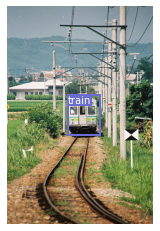

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(opt.model_def, img_size=opt.img_size).to(device)

if opt.weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(opt.weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(opt.weights_path))

model.eval()  # Set in evaluation mode

dataloader = DataLoader(
    ImageFolder(opt.image_folder, img_size=opt.img_size),
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_cpu,
)

classes = load_classes(opt.class_path)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index

print("\nPerforming object detection:")
prev_time = time.time()
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)

    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)

# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))

    # Create plot
    img = np.array(Image.open(path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, opt.img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = path.split("/")[-1].split(".")[0]
    plt.savefig(f"output/{filename}.png", bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()